In [1]:
import pandas as pd

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 20, 6
rcParams['lines.linewidth'] = 2.5

# Data

In [3]:
GHI_cs = pd.read_csv('data/Ineichen_clear_sky_model.csv', index_col='Unnamed: 0')[:'2023-06-01 01']

In [4]:
GHI_cs = GHI_cs.drop('dhi', axis = 1)
GHI_cs = GHI_cs.drop('dni', axis = 1)

In [5]:
GHI_m = pd.read_csv('data/Rayonnement solaire-data-2023-06-13 09_46_08.csv', index_col='Time')[:'2023-06-01 01']

In [6]:
GHI_m.columns = ['ghi_m']

In [7]:
GHI_cs.index = pd.to_datetime(GHI_cs.index, format ='%Y-%m-%d %H:%M:%S') 
GHI_cs =GHI_cs.tz_convert('Europe/Paris').tz_localize(None)


In [8]:
GHI_m.index = pd.to_datetime(GHI_m.index, format ='%Y-%m-%d %H:%M:%S')
GHI_m = GHI_m.tz_localize('UTC').tz_localize(None)

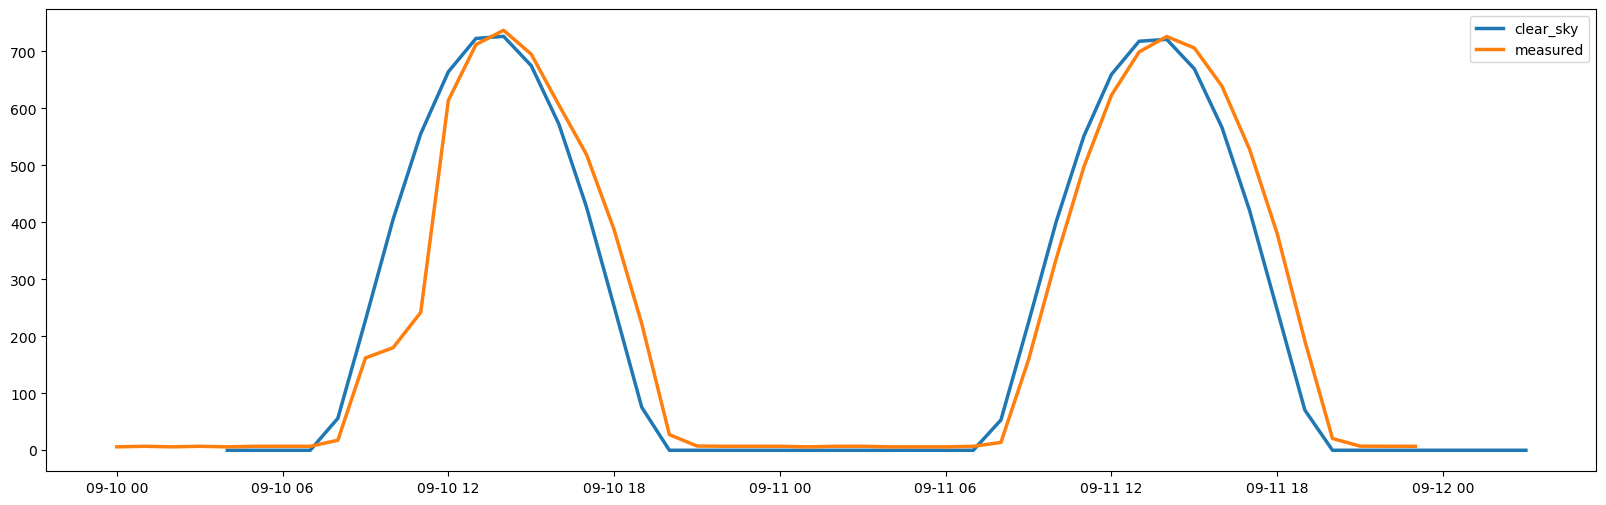

In [9]:
plt.plot(GHI_cs[:48], label='clear_sky')
plt.plot(GHI_m[:48], label='measured')
plt.legend()
plt.show()

In [10]:
GHI_m = GHI_m['2022-09-10 04:00:00':'2023-06-01 00']

In [11]:
GHI_cs = GHI_cs['2022-09-10 04:00:00':'2023-06-01 00']

In [12]:
neb =pd.read_csv("data/neb.csv", index_col='Date')
neb

nebulosity
Date                            
2022-09-10 00:00:00     0.552006
2022-09-10 01:00:00     0.538226
2022-09-10 02:00:00     0.593627
2022-09-10 03:00:00     0.590393
2022-09-10 04:00:00     0.900041
...                          ...
2023-05-31 20:00:00     0.607466
2023-05-31 21:00:00     0.436023
2023-05-31 22:00:00     0.325349
2023-05-31 23:00:00     0.873555
2023-06-01 00:00:00     0.571237

[6337 rows x 1 columns]

In [13]:
GHI_cs/= 1000
GHI_m/=1000

In [14]:
neb.index = pd.to_datetime(neb.index, format ='%Y-%m-%d %H:%M:%S')
neb= neb ['2022-09-10 04:00:00':'2023-06-01 00']

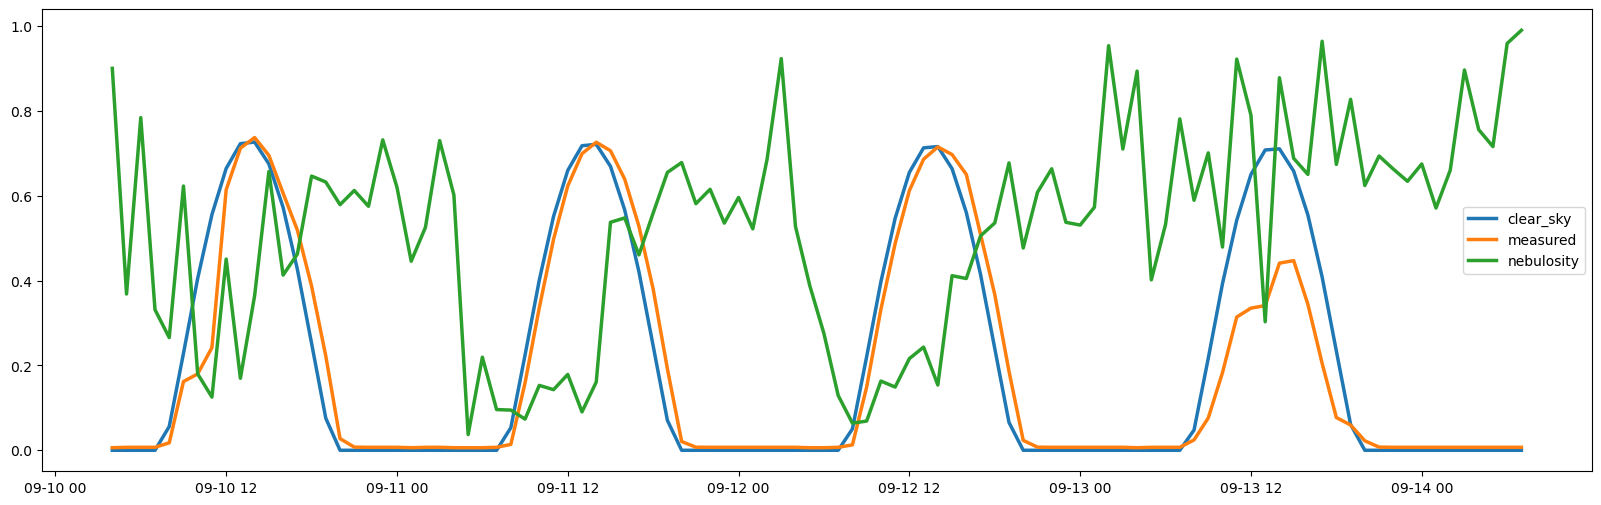

In [15]:
plt.plot(GHI_cs[:100], label='clear_sky')
plt.plot(GHI_m[:100], label='measured')
plt.plot(neb[:100], label = 'nebulosity')
plt.legend()
plt.show()

In [16]:
neb.index = GHI_cs.index
GHI_m.index = GHI_cs.index

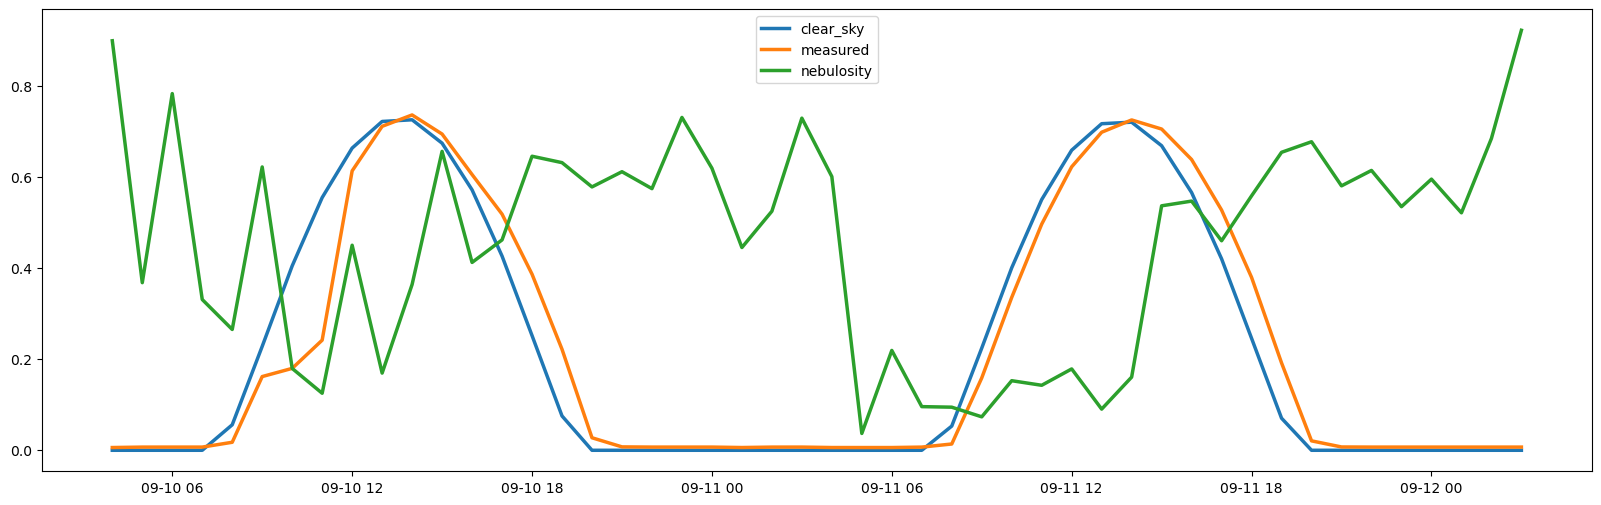

In [17]:
plt.plot(GHI_cs[:48], label='clear_sky')
plt.plot(GHI_m[:48], label='measured')
plt.plot(neb[:48], label = 'nebulosity')
plt.legend()
plt.show()

In [18]:
df = neb.copy()
df['ghi_m'] = GHI_m['ghi_m']
df['ghi_cs'] = GHI_cs['ghi']

In [19]:
df

nebulosity    ghi_m    ghi_cs
2022-09-10 04:00:00     0.900041  0.00603  0.000000
2022-09-10 05:00:00     0.368325  0.00697  0.000000
2022-09-10 06:00:00     0.783914  0.00700  0.000000
2022-09-10 07:00:00     0.331366  0.00700  0.000000
2022-09-10 08:00:00     0.265519  0.01760  0.056038
...                          ...      ...       ...
2023-05-31 20:00:00     0.607466  0.05070  0.095277
2023-05-31 21:00:00     0.436023  0.01460  0.000876
2023-05-31 22:00:00     0.325349  0.00712  0.000000
2023-05-31 23:00:00     0.873555  0.00700  0.000000
2023-06-01 00:00:00     0.571237  0.00602  0.000000

[6333 rows x 3 columns]

# Training

## Train on september

In [22]:
def split_set(df, start, end, batch_size):
    df_ = df[start:end].to_numpy()
    df_ = torch.tensor(df_, dtype=torch.float32)
    my_dataset = TensorDataset(df_) # create your datset
    my_dataloader = DataLoader(my_dataset, batch_size=24)

    return my_dataloader

In [22]:
my_dataloader = split_set(df,'2022-09-01', '2022-10-01',24)

In [23]:
train = df[:][:'2022-10-01']
test = df[:]['2022-10-01':'2022-11-25']

In [24]:
X_train = torch.tensor(train.values, dtype=torch.float32)

In [25]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [26]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [147]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3, 24)
        self.hidden2 = nn.Linear(24, 24)
        self.output1 = nn.Linear(24, 1)
        self.output2 = nn.Linear(24, 1)
 
 
    def forward(self, x):
        x = (self.hidden1(x))
        x =(self.hidden2(x))
        output1 = (self.output1(x))
        output2 = (self.output2(x))
        return output1, output2

In [29]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (hidden1): Linear(in_features=3, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=24, bias=True)
  (output1): Linear(in_features=24, out_features=1, bias=True)
  (output2): Linear(in_features=24, out_features=1, bias=True)
)


In [30]:
neb_ = torch.tensor(neb.values, dtype=torch.float32)

In [31]:
GHI_cs_ = torch.tensor(GHI_cs.values, dtype=torch.float32)
GHI_m_ = torch.tensor(GHI_m.values, dtype=torch.float32)

In [32]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
n_epochs = 250
batch_size = 24
 
for epoch in range(n_epochs):
    for index in my_dataloader:
        # print(index)
        y_pred = model(index[0])
        a, n1 = y_pred
        # calculating squared difference between target and predicted values 
        diff = torch.square(index[0][:,1] - (1- (a * torch.pow(index[0][:,0], n1)))* index[0][:,2])
        loss = torch.sum(diff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 16.150583267211914
Finished epoch 1, latest loss 8.387624740600586
Finished epoch 2, latest loss 7.962704658508301
Finished epoch 3, latest loss 7.266488552093506
Finished epoch 4, latest loss 6.513692378997803
Finished epoch 5, latest loss 6.0752434730529785
Finished epoch 6, latest loss 5.784852027893066
Finished epoch 7, latest loss 5.555134296417236
Finished epoch 8, latest loss 5.373932838439941
Finished epoch 9, latest loss 5.228904724121094
Finished epoch 10, latest loss 5.108256816864014
Finished epoch 11, latest loss 5.005244731903076
Finished epoch 12, latest loss 4.915571689605713
Finished epoch 13, latest loss 4.836119174957275
Finished epoch 14, latest loss 4.764684677124023
Finished epoch 15, latest loss 4.699708938598633
Finished epoch 16, latest loss 4.640063285827637
Finished epoch 17, latest loss 4.584920883178711
Finished epoch 18, latest loss 4.533679962158203
Finished epoch 19, latest loss 4.48588752746582
Finished epoch 20, latest los

Test on trained data

In [34]:
a, n = model(X_train)

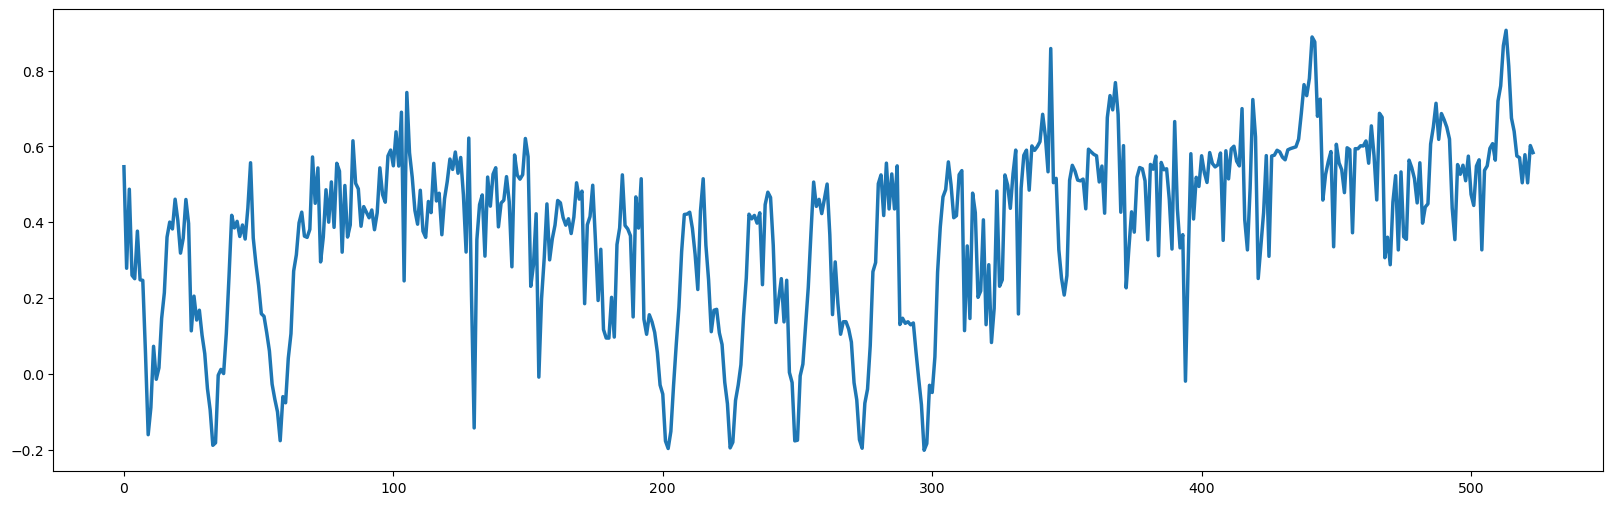

In [35]:
plt.plot(a.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


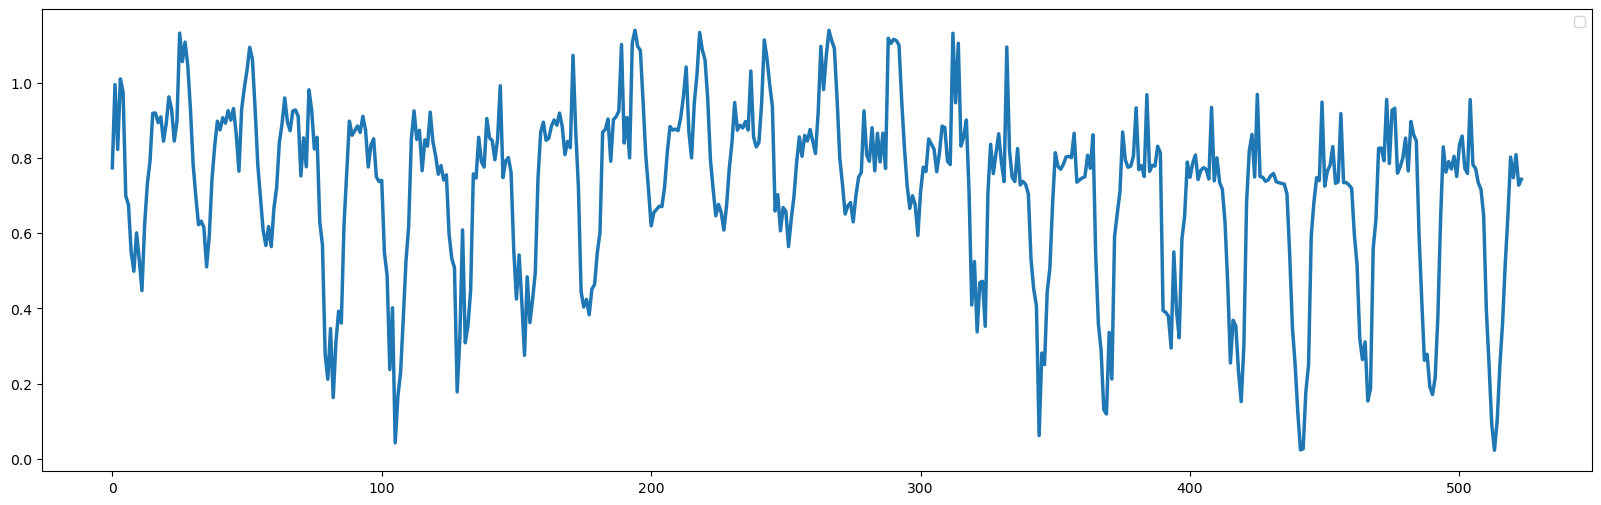

In [36]:

plt.plot(n.detach().numpy().flatten())
plt.legend()
plt.show()

In [37]:
len(a)

524

In [38]:
ghi_cs = df['ghi_cs'][:'2022-10-01']

In [39]:
neb = df[' nebulosity'][:'2022-10-01']

In [40]:
pred = GHI_cs.copy()[:'2022-10-01']
pred.columns = ['pred_']

In [41]:
pred

pred_
2022-09-10 04:00:00  0.000000
2022-09-10 05:00:00  0.000000
2022-09-10 06:00:00  0.000000
2022-09-10 07:00:00  0.000000
2022-09-10 08:00:00  0.056038
...                       ...
2022-10-01 19:00:00  0.003049
2022-10-01 20:00:00  0.000000
2022-10-01 21:00:00  0.000000
2022-10-01 22:00:00  0.000000
2022-10-01 23:00:00  0.000000

[524 rows x 1 columns]

In [42]:
pred['pred_'] = ((1-a.detach().numpy().flatten()*np.power(neb.to_numpy(), n.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [43]:
true = GHI_m[:'2022-10-01']*1000

In [44]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 60.74 RMSE
RMSE en % :  8.175421364429171


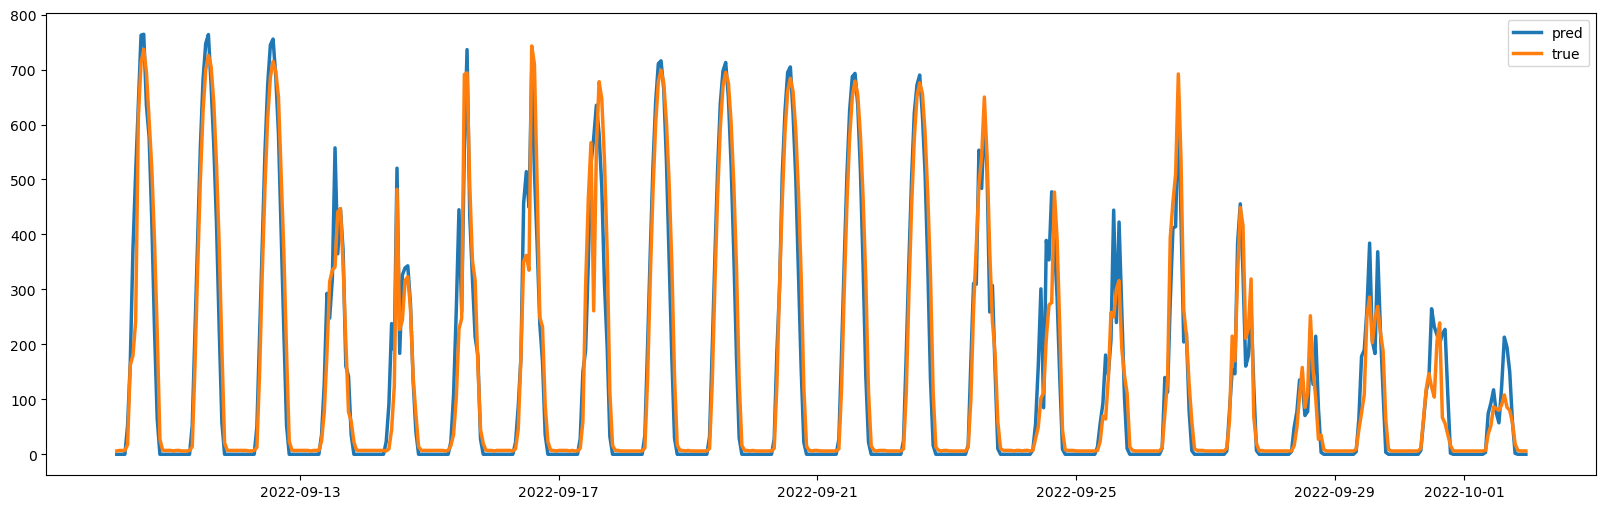

In [45]:
plt.plot(pred, label = 'pred')
plt.plot(true, label = 'true')
plt.legend()
plt.show()


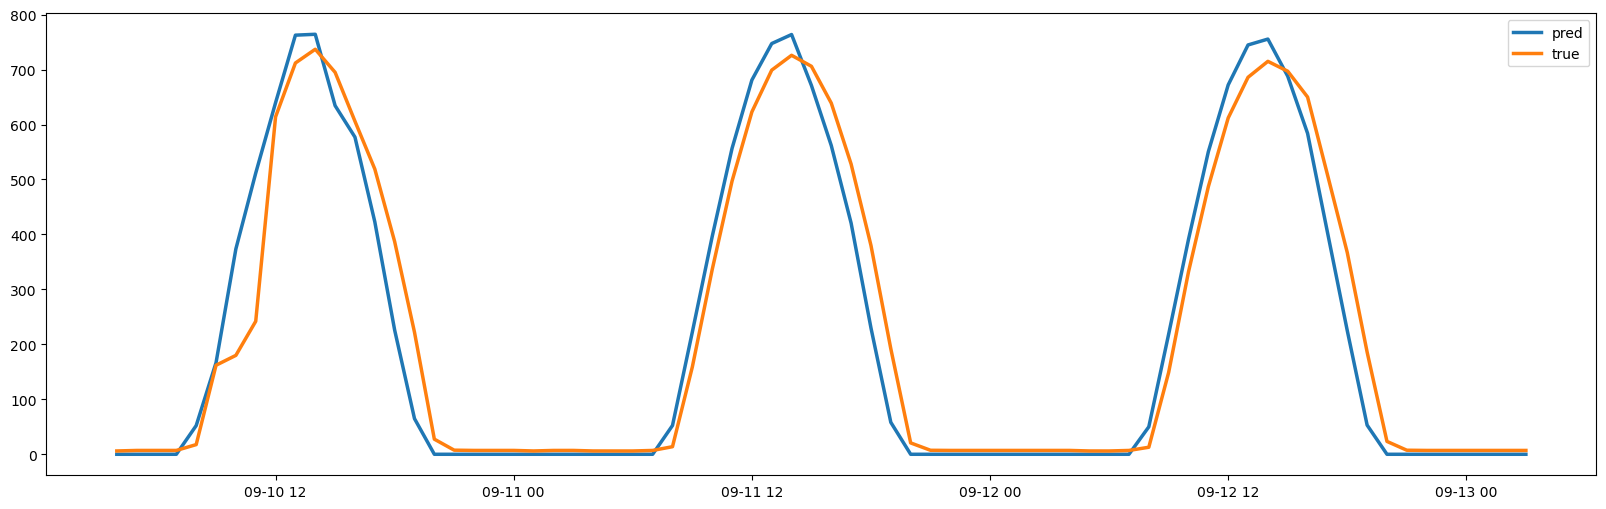

In [46]:
plt.plot(pred[:72], label = 'pred')
plt.plot(true[:72], label = 'true')
plt.legend()
plt.show()

In [47]:
# torch.save(model.state_dict(), 'models/model_ss_fact_bis.pth')

## Test btw ['2022-10-01':'2022-11-25']

In [48]:
a_test, n_test = model(X_test)

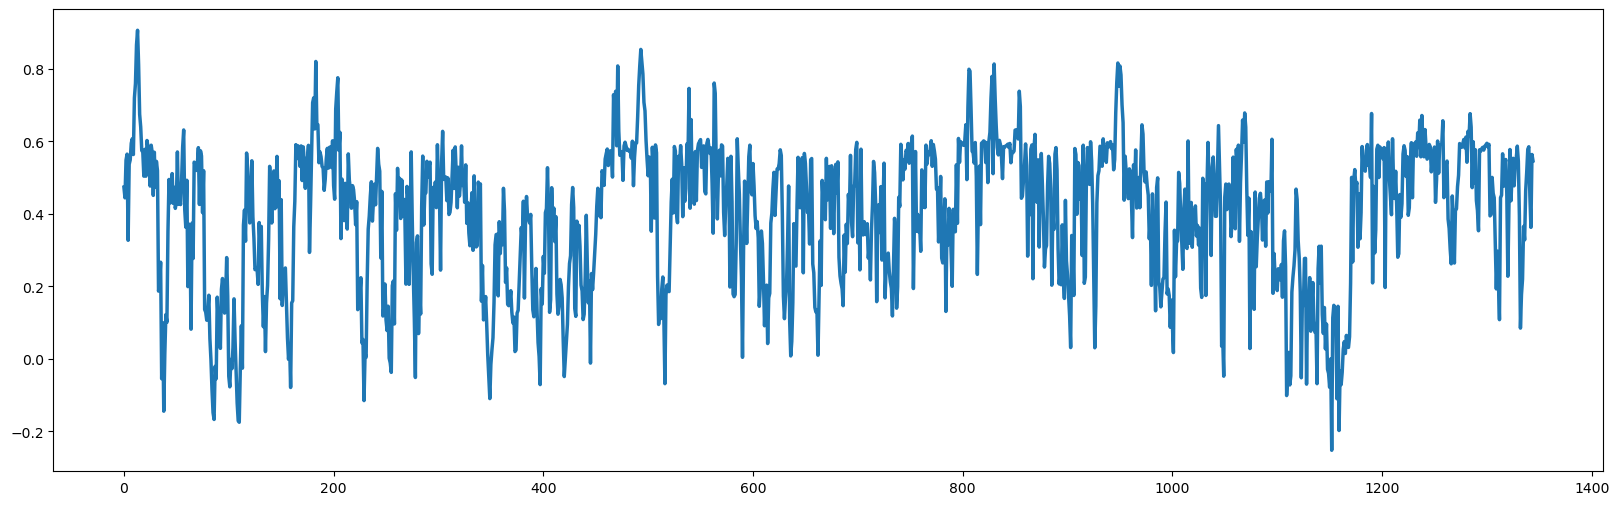

In [49]:
plt.plot(a_test.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


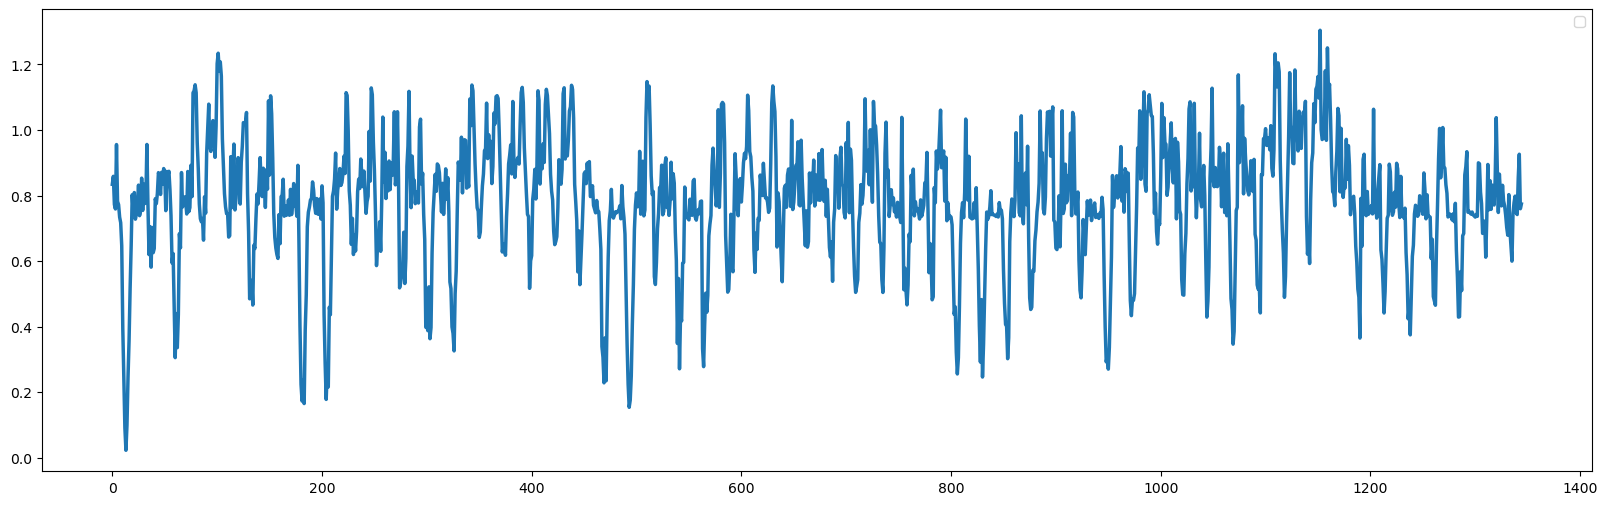

In [50]:

plt.plot(n_test.detach().numpy().flatten())
plt.legend()
plt.show()

In [51]:
len(a_test)

1345

In [52]:
ghi_cs_test = df['ghi_cs']['2022-10-01':'2022-11-25']

In [53]:
neb_test = df[' nebulosity']['2022-10-01':'2022-11-25']

In [54]:
pred_test = GHI_cs.copy()['2022-10-01':'2022-11-25']
pred_test.columns = ['pred_']

In [55]:
pred_test

pred_
2022-10-01 00:00:00    0.0
2022-10-01 01:00:00    0.0
2022-10-01 02:00:00    0.0
2022-10-01 03:00:00    0.0
2022-10-01 04:00:00    0.0
...                    ...
2022-11-25 19:00:00    0.0
2022-11-25 20:00:00    0.0
2022-11-25 21:00:00    0.0
2022-11-25 22:00:00    0.0
2022-11-25 23:00:00    0.0

[1345 rows x 1 columns]

In [56]:
pred_test['pred_'] = ((1-a_test.detach().numpy().flatten()*np.power(neb_test.to_numpy(), n_test.detach().numpy().flatten()))* ghi_cs_test.to_numpy())*1000

In [57]:
true_test = GHI_m['2022-10-01':'2022-11-25']*1000

In [58]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true_test.values, pred_test.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true_test.values.max())

Test Score: 83.04 RMSE
RMSE en % :  13.28599943167123


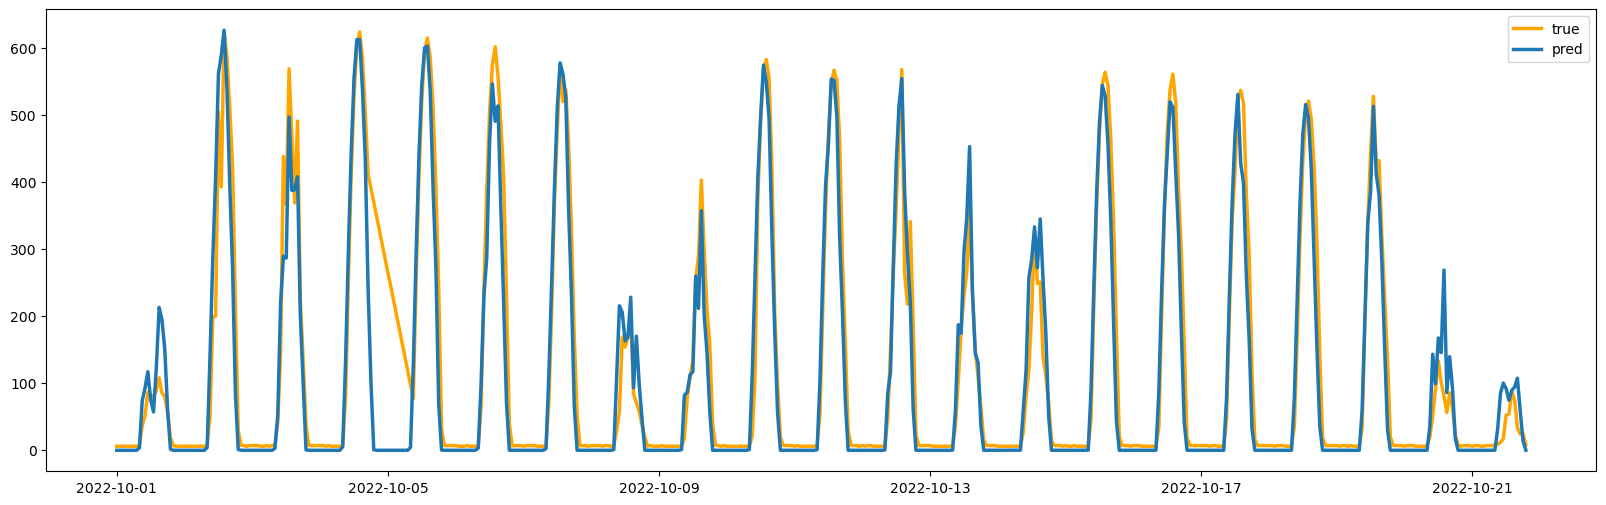

In [59]:
plt.plot(true_test[:500], label = 'true', color = 'orange')
plt.plot(pred_test[:500], label = 'pred')
plt.legend()
plt.show()


## Test btw ['2023-04-01':'2023-05-30']

In [60]:
test = df[:]['2023-04-01':'2023-05-30']

In [61]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [62]:
a_test, n_test = model(X_test)

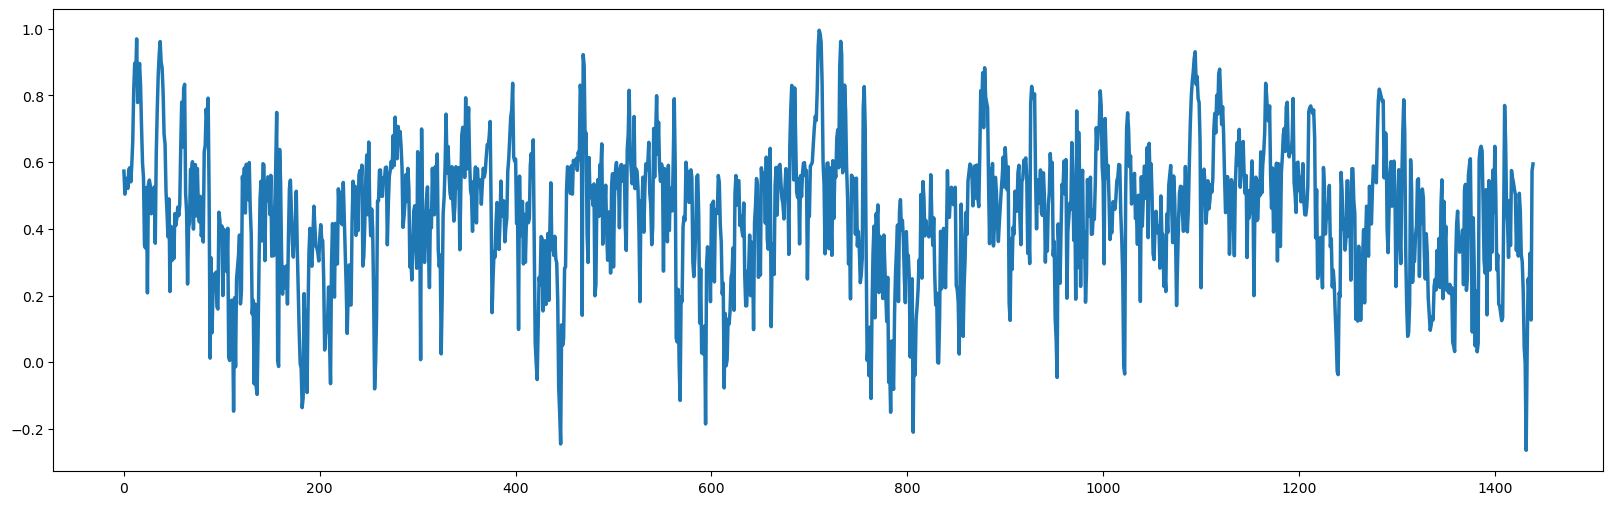

In [63]:
plt.plot(a_test.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


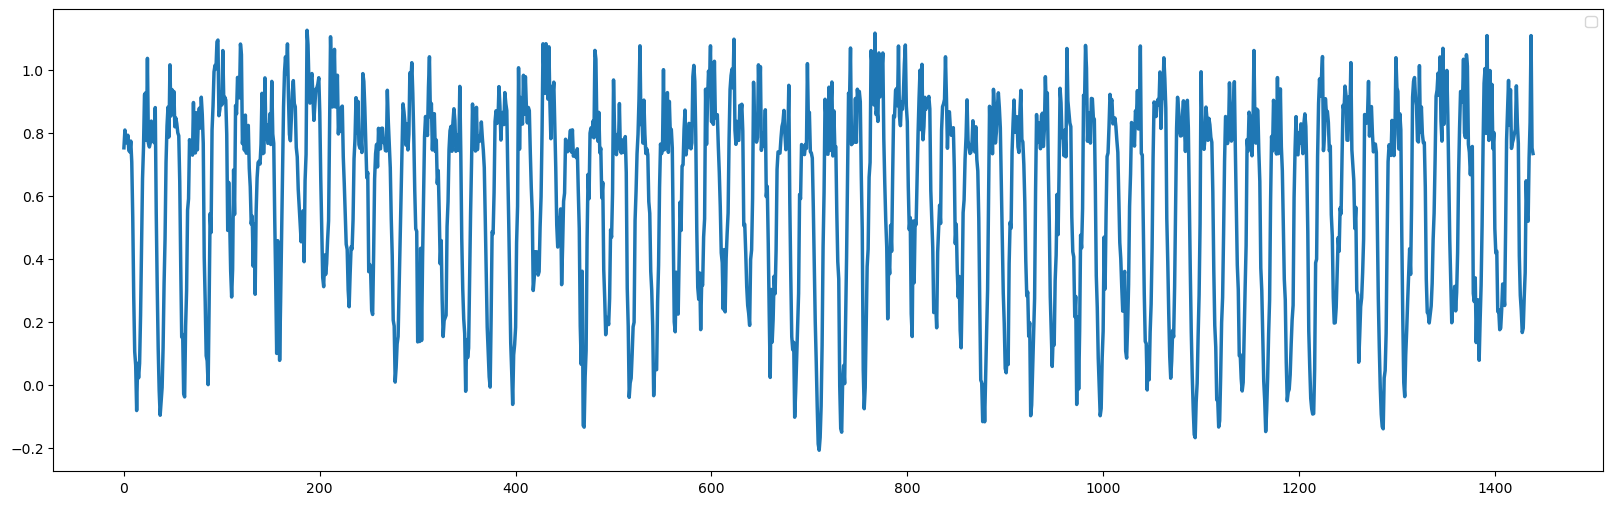

In [64]:

plt.plot(n_test.detach().numpy().flatten())
plt.legend()
plt.show()

In [65]:
len(a_test)

1440

In [66]:
ghi_cs_test = df['ghi_cs']['2023-04-01':'2023-05-30']

In [67]:
neb_test = df[' nebulosity']['2023-04-01':'2023-05-30']

In [68]:
pred_test = GHI_cs.copy()['2023-04-01':'2023-05-30']
pred_test.columns = ['pred_']

In [69]:
pred_test

pred_
2023-04-01 00:00:00  0.000000
2023-04-01 01:00:00  0.000000
2023-04-01 02:00:00  0.000000
2023-04-01 03:00:00  0.000000
2023-04-01 04:00:00  0.000000
...                       ...
2023-05-30 19:00:00  0.265082
2023-05-30 20:00:00  0.093250
2023-05-30 21:00:00  0.000702
2023-05-30 22:00:00  0.000000
2023-05-30 23:00:00  0.000000

[1440 rows x 1 columns]

In [70]:
pred_test['pred_'] = ((1-a_test.detach().numpy().flatten()*np.power(neb_test.to_numpy(), n_test.detach().numpy().flatten()))* ghi_cs_test.to_numpy())*1000

In [71]:
true_test = GHI_m['2023-04-01':'2023-05-30']*1000

In [72]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true_test.values, pred_test.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true_test.values.max())

Test Score: 64.73 RMSE
RMSE en % :  7.176315950358137


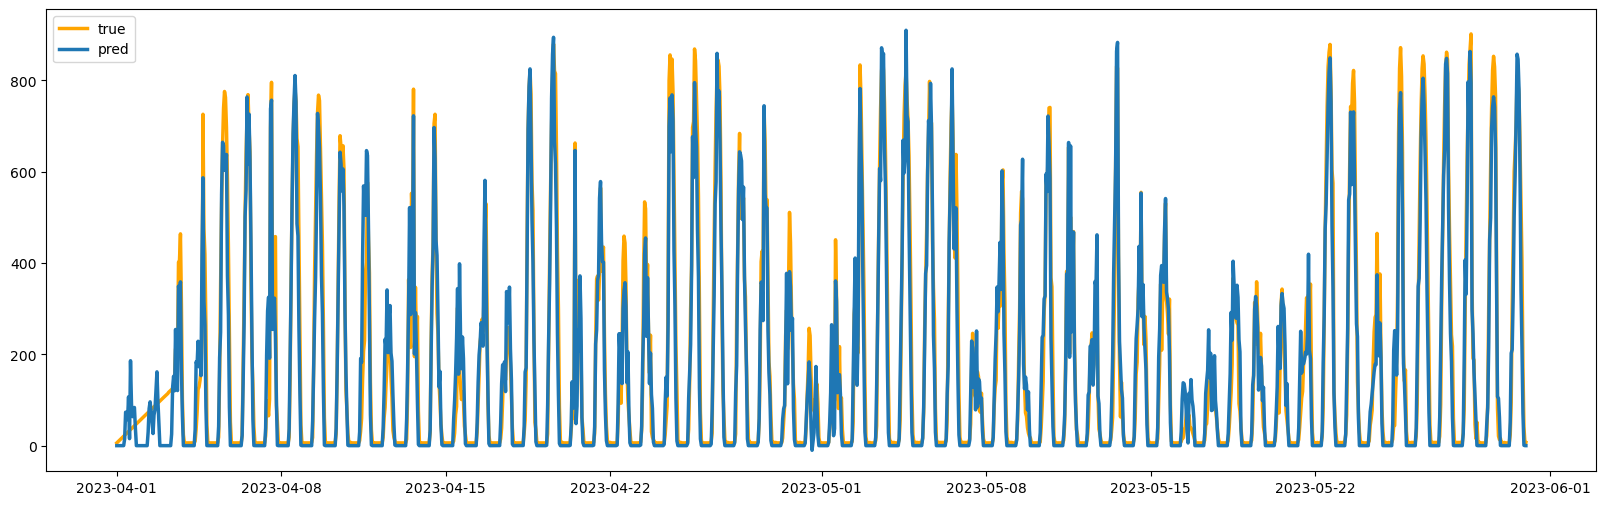

In [73]:
plt.plot(true_test, label = 'true', color = 'orange')
plt.plot(pred_test, label = 'pred')
plt.legend()
plt.show()


## Test on feb-june

In [74]:
test = df[:]['2023-02-01':]

In [75]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [76]:
a, n = model(X_test)

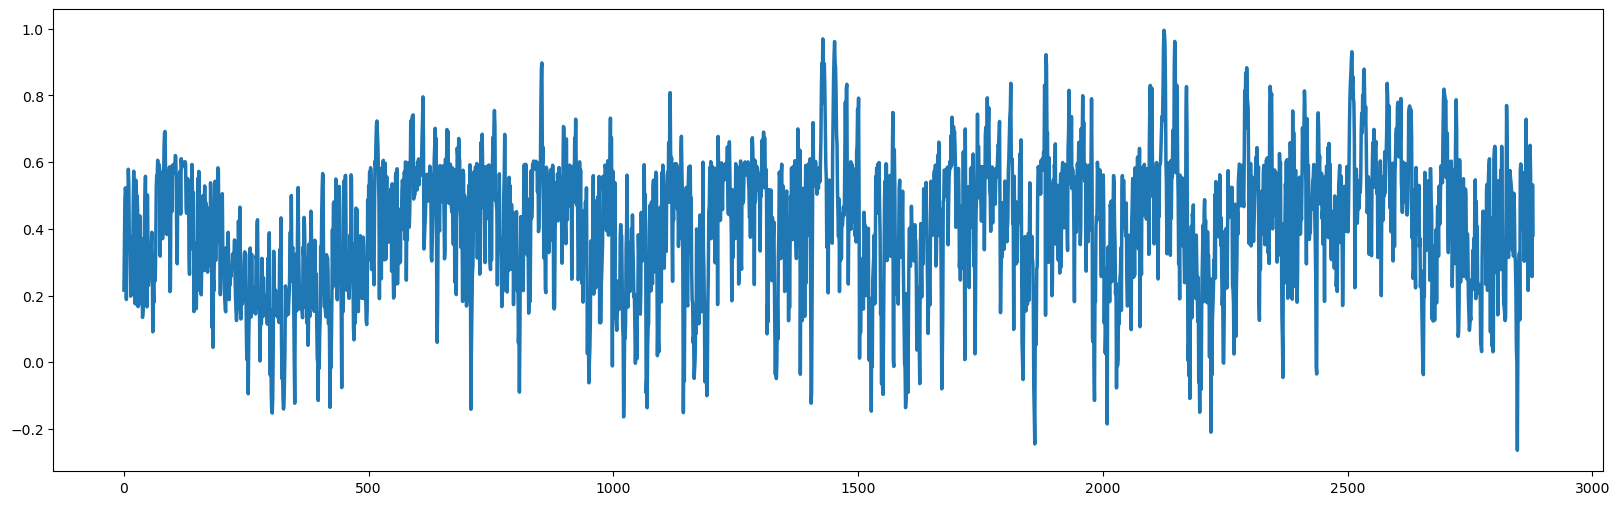

In [77]:
plt.plot(a.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


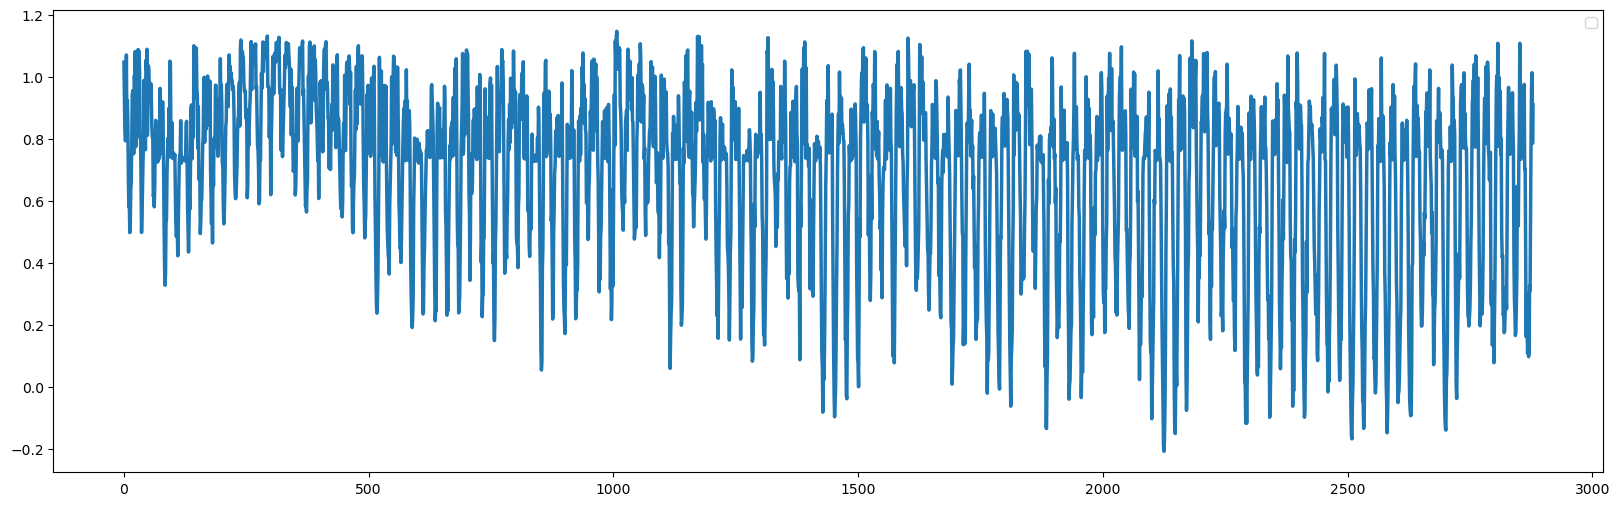

In [78]:

plt.plot(n.detach().numpy().flatten())
plt.legend()
plt.show()

In [79]:
len(a)

2880

In [80]:
ghi_cs = df['ghi_cs']['2023-02-01':]

In [81]:
neb = df[' nebulosity']['2023-02-01':]

In [82]:
pred = GHI_cs.copy()['2023-02-01':]
pred.columns = ['pred_']

In [83]:
pred

pred_
2023-02-01 00:00:00  0.000000
2023-02-01 01:00:00  0.000000
2023-02-01 02:00:00  0.000000
2023-02-01 03:00:00  0.000000
2023-02-01 04:00:00  0.000000
...                       ...
2023-05-31 20:00:00  0.095277
2023-05-31 21:00:00  0.000876
2023-05-31 22:00:00  0.000000
2023-05-31 23:00:00  0.000000
2023-06-01 00:00:00  0.000000

[2880 rows x 1 columns]

In [84]:
pred['pred_'] = ((1-a.detach().numpy().flatten()*np.power(neb.to_numpy(), n.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [85]:
true = GHI_m['2023-02-01':]*1000

In [86]:
pred[pred['pred_'].isna()] = 0

In [87]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 66.21 RMSE
RMSE en % :  7.340153171080945


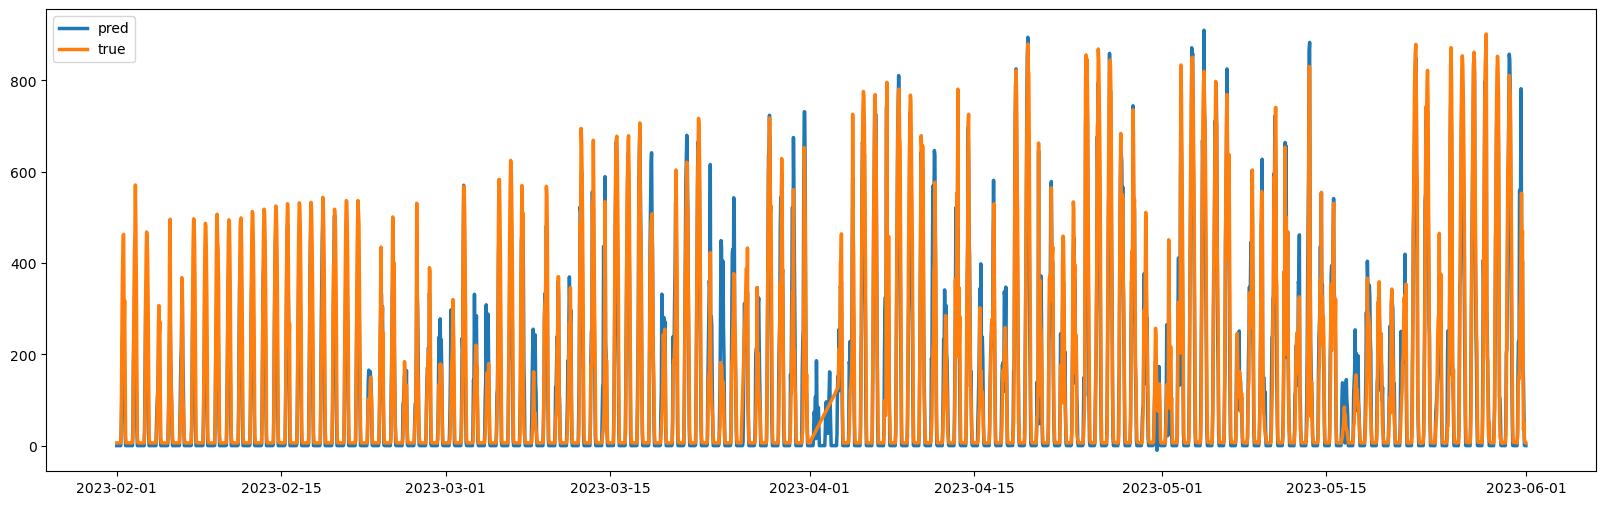

In [88]:
plt.plot(pred, label = 'pred')
plt.plot(true, label = 'true')
plt.legend()
plt.show()


## Train on september and october

In [196]:
my_dataloader = split_set(df, '2022-09-01', '2022-11-01', 24)

In [197]:
train = df[:][:'2022-11-01']
test = df[:]['2022-10-01':'2022-11-25']

In [198]:
X_train = torch.tensor(train.values, dtype=torch.float32)

In [199]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [258]:
model2 = NeuralNetwork()

In [259]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [260]:
n_epochs = 250
batch_size = 24
 
for epoch in range(n_epochs):
    for index in my_dataloader:
        # print(index[0].shape)
        y_pred = model2(index[0])
        a, n1 = y_pred
        # calculating squared difference between target and predicted values 
        diff = torch.square(index[0][:,1] - (1- (a * torch.pow(index[0][:,0], n1)))* index[0][:,2])
        loss = torch.sum(diff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 2.82332444190979
Finished epoch 1, latest loss 3.1575279235839844
Finished epoch 2, latest loss 3.400519847869873
Finished epoch 3, latest loss 3.5836920738220215
Finished epoch 4, latest loss 3.7110118865966797
Finished epoch 5, latest loss 3.7945501804351807
Finished epoch 6, latest loss 3.8446168899536133
Finished epoch 7, latest loss 3.86977481842041
Finished epoch 8, latest loss 3.8771755695343018
Finished epoch 9, latest loss 3.8727707862854004
Finished epoch 10, latest loss 3.861419439315796
Finished epoch 11, latest loss 3.8469200134277344
Finished epoch 12, latest loss 3.8320236206054688
Finished epoch 13, latest loss 3.81850528717041
Finished epoch 14, latest loss 3.807305335998535
Finished epoch 15, latest loss 3.79872989654541
Finished epoch 16, latest loss 3.7926626205444336
Finished epoch 17, latest loss 3.7887628078460693
Finished epoch 18, latest loss 3.7866086959838867
Finished epoch 19, latest loss 3.785792827606201
Finished epoch 20, lat

In [261]:
a, n = model2(X_train)

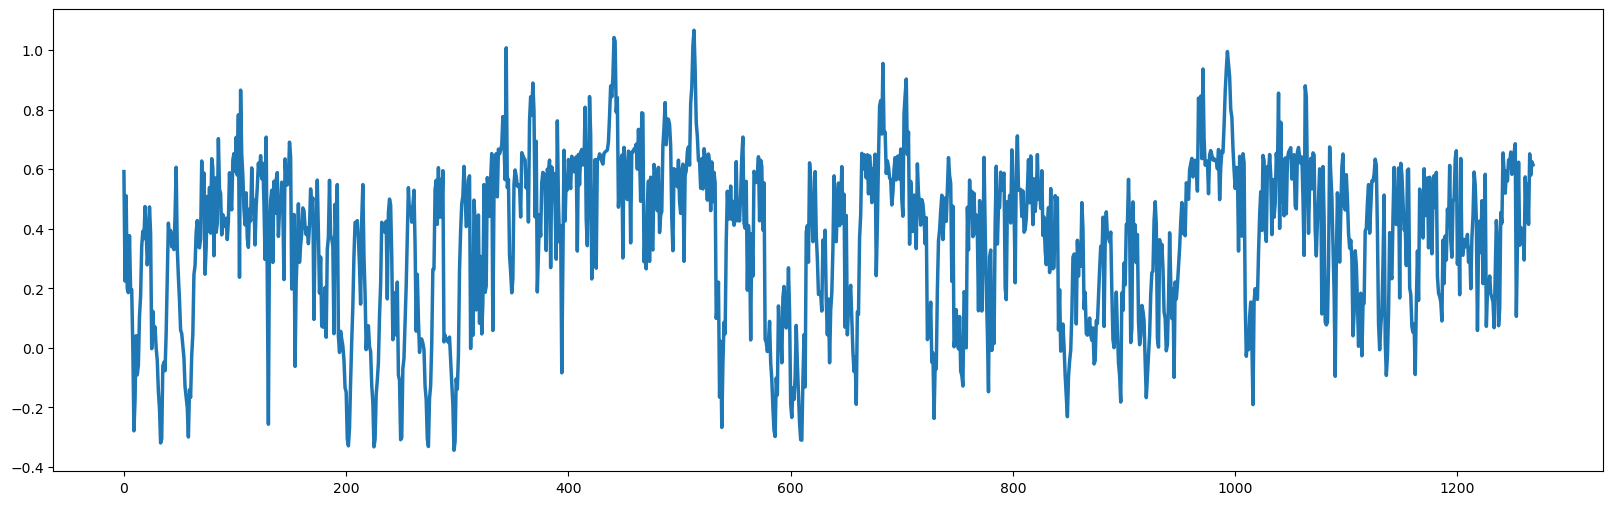

In [262]:
plt.plot(a.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


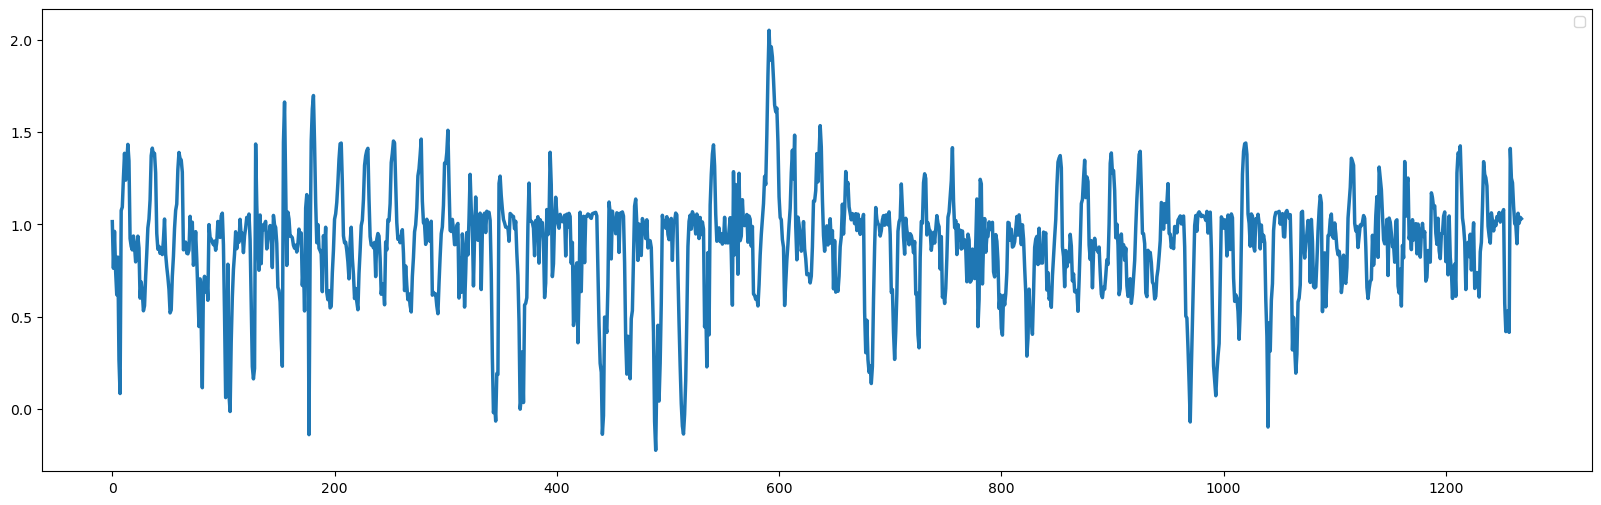

In [263]:

plt.plot(n.detach().numpy().flatten())
plt.legend()
plt.show()

In [264]:
len(a)

1269

In [265]:
ghi_cs = df['ghi_cs'][:'2022-11-01']

In [266]:
neb = df[' nebulosity'][:'2022-11-01']

In [267]:
pred = GHI_cs.copy()[:'2022-11-01']
pred.columns = ['pred_']

In [268]:
pred

pred_
2022-09-10 04:00:00  0.000000
2022-09-10 05:00:00  0.000000
2022-09-10 06:00:00  0.000000
2022-09-10 07:00:00  0.000000
2022-09-10 08:00:00  0.056038
...                       ...
2022-11-01 19:00:00  0.000000
2022-11-01 20:00:00  0.000000
2022-11-01 21:00:00  0.000000
2022-11-01 22:00:00  0.000000
2022-11-01 23:00:00  0.000000

[1269 rows x 1 columns]

In [269]:
pred['pred_'] = ((1-a.detach().numpy().flatten()*np.power(neb.to_numpy(), n.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [270]:
true = GHI_m[:'2022-11-01']*1000

In [271]:
pred[pred['pred_'].isna()] = 0

In [272]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 58.78 RMSE
RMSE en % :  7.911220774763271


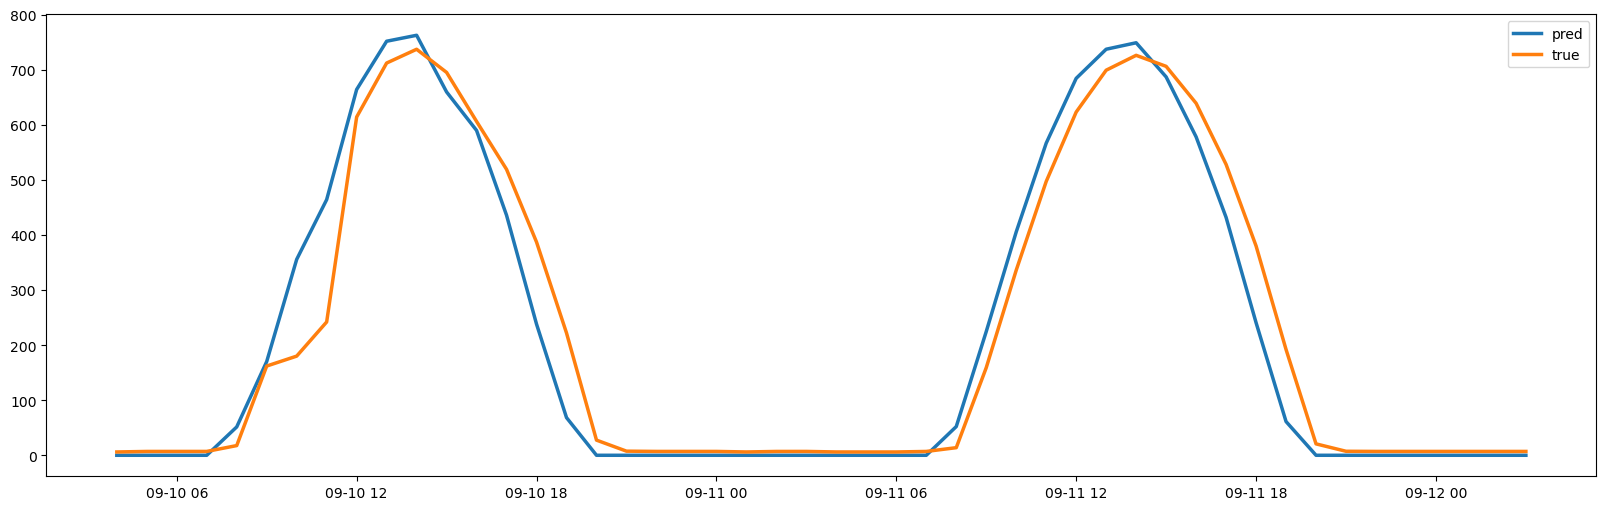

In [273]:
plt.plot(pred[:48], label = 'pred')
plt.plot(true[:48], label = 'true')
plt.legend()
plt.show()


Trained on ~2 months and test on the rest of the dataset

In [274]:
test = df[:]['2022-11-01':]

In [275]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [276]:
a, n = model2(X_test)

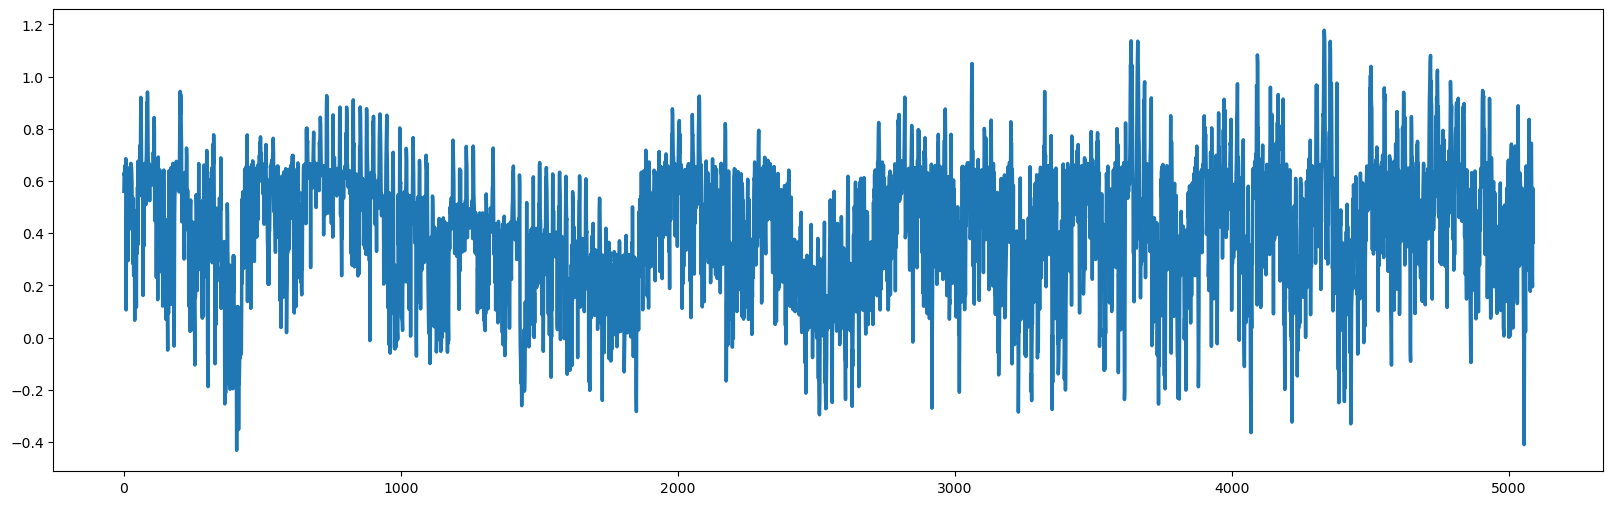

In [277]:
plt.plot(a.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


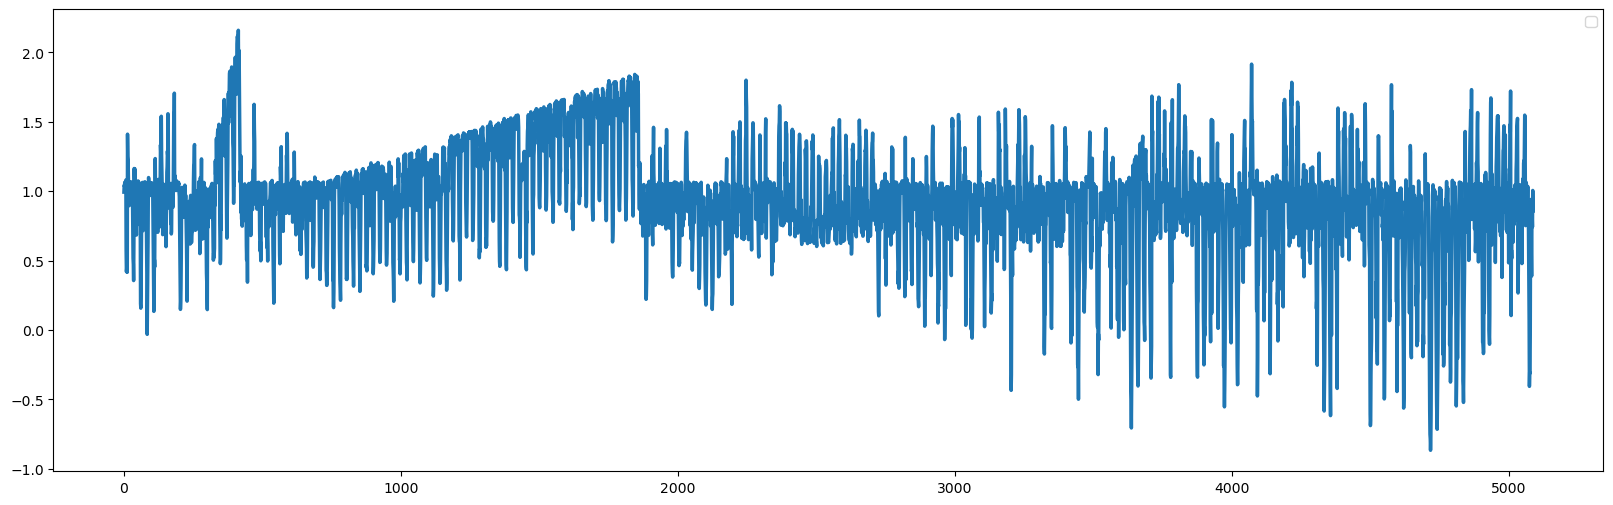

In [278]:

plt.plot(n.detach().numpy().flatten())
plt.legend()
plt.show()

In [279]:
len(a)

5088

In [280]:
ghi_cs = df['ghi_cs']['2022-11-01':]

In [281]:
neb = df[' nebulosity']['2022-11-01':]

In [282]:
pred = GHI_cs.copy()['2022-11-01':]
pred.columns = ['pred_']

In [283]:
pred

pred_
2022-11-01 00:00:00  0.000000
2022-11-01 01:00:00  0.000000
2022-11-01 02:00:00  0.000000
2022-11-01 03:00:00  0.000000
2022-11-01 04:00:00  0.000000
...                       ...
2023-05-31 20:00:00  0.095277
2023-05-31 21:00:00  0.000876
2023-05-31 22:00:00  0.000000
2023-05-31 23:00:00  0.000000
2023-06-01 00:00:00  0.000000

[5088 rows x 1 columns]

In [284]:
pred['pred_'] = ((1-a.detach().numpy().flatten()*np.power(neb.to_numpy(), n.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [285]:
true = GHI_m['2022-11-01':]*1000

In [286]:
pred[pred['pred_'].isna()] = 0

In [287]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 93.01 RMSE
RMSE en % :  10.311925629831515


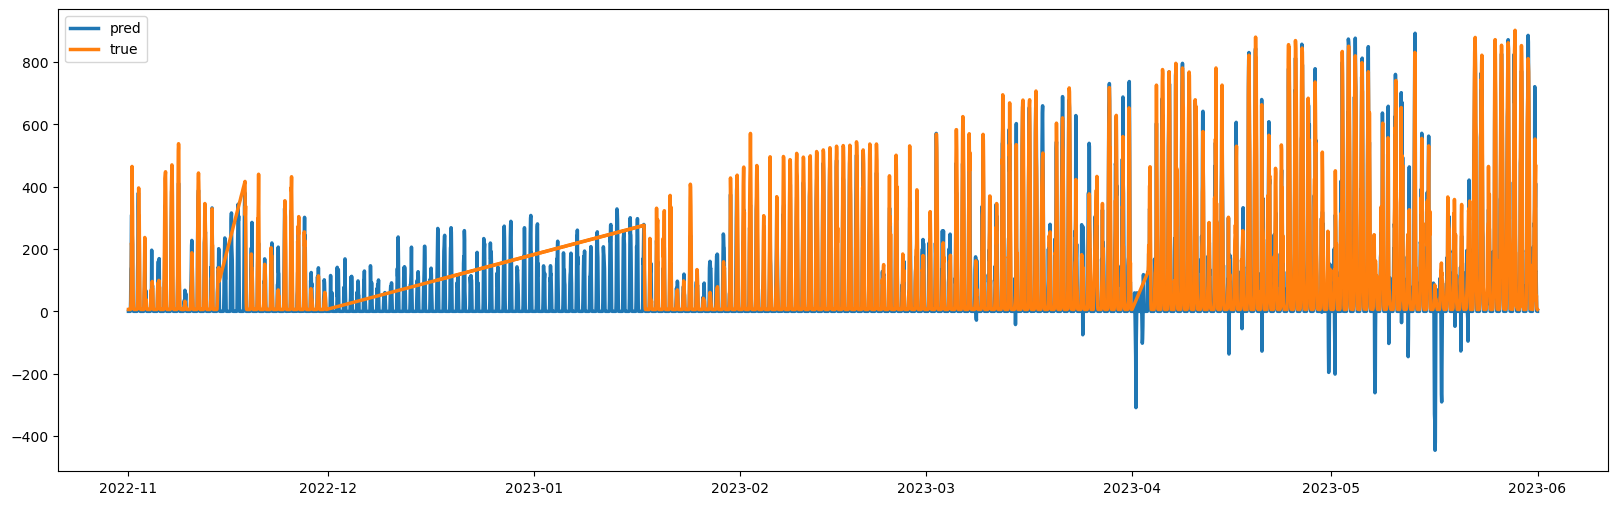

In [288]:
plt.plot(pred, label = 'pred')
plt.plot(true, label = 'true')
plt.legend()
plt.show()


There is missing data so me test from february till june

In [289]:
test = df[:]['2023-02-01':]

In [290]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [291]:
a, n = model2(X_test)

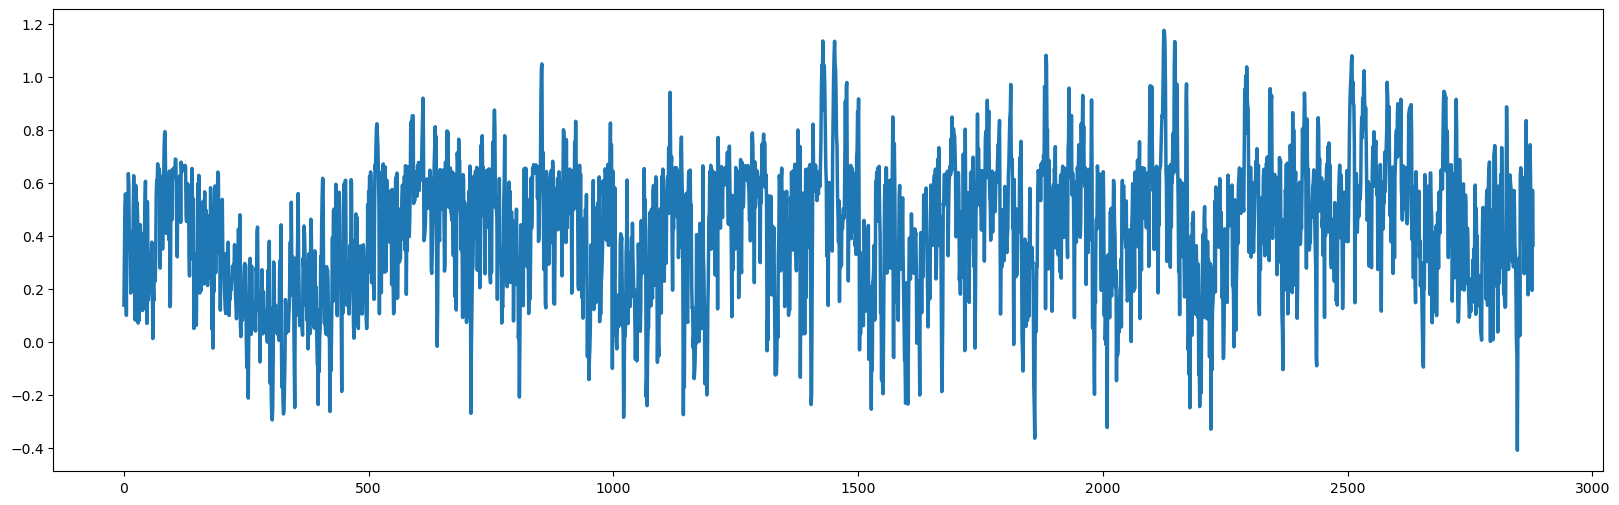

In [292]:
plt.plot(a.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


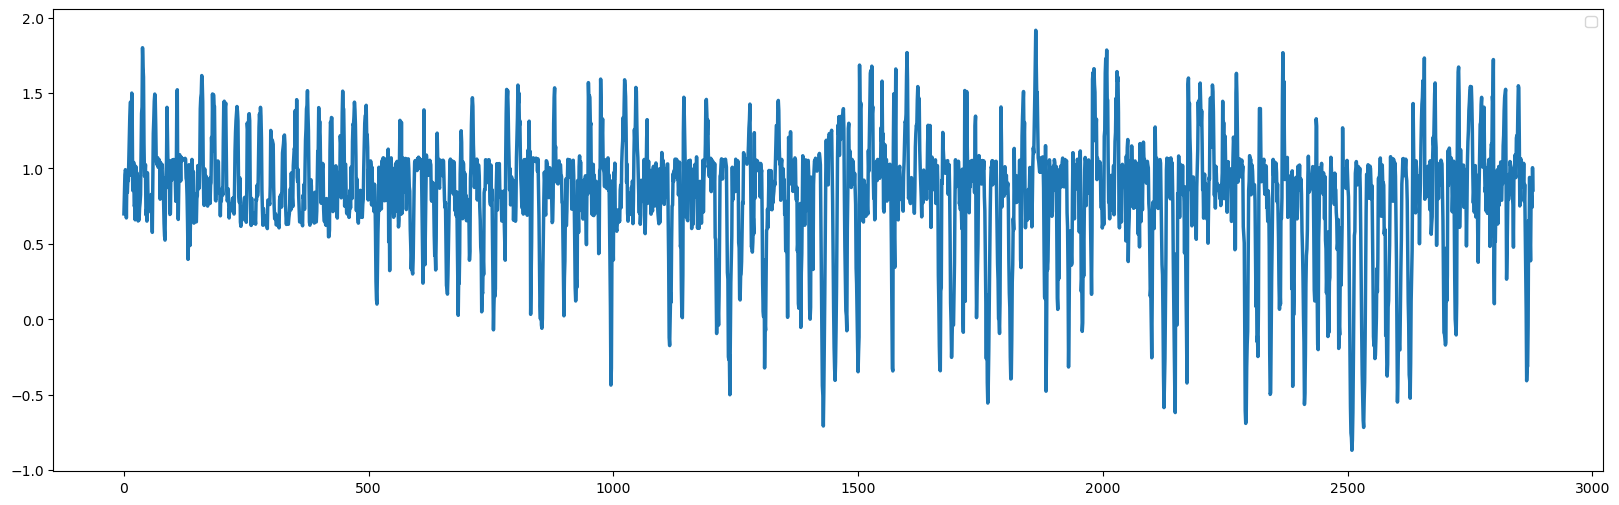

In [293]:

plt.plot(n.detach().numpy().flatten())
plt.legend()
plt.show()

In [294]:
len(a)

2880

In [295]:
ghi_cs = df['ghi_cs']['2023-02-01':]

In [296]:
neb = df[' nebulosity']['2023-02-01':]

In [297]:
pred = GHI_cs.copy()['2023-02-01':]
pred.columns = ['pred_']

In [298]:
pred

pred_
2023-02-01 00:00:00  0.000000
2023-02-01 01:00:00  0.000000
2023-02-01 02:00:00  0.000000
2023-02-01 03:00:00  0.000000
2023-02-01 04:00:00  0.000000
...                       ...
2023-05-31 20:00:00  0.095277
2023-05-31 21:00:00  0.000876
2023-05-31 22:00:00  0.000000
2023-05-31 23:00:00  0.000000
2023-06-01 00:00:00  0.000000

[2880 rows x 1 columns]

In [299]:
pred['pred_'] = ((1-a.detach().numpy().flatten()*np.power(neb.to_numpy(), n.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [300]:
true = GHI_m['2023-02-01':]*1000

In [301]:
pred[pred['pred_'].isna()] = 0

In [302]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 70.80 RMSE
RMSE en % :  7.848734662545105


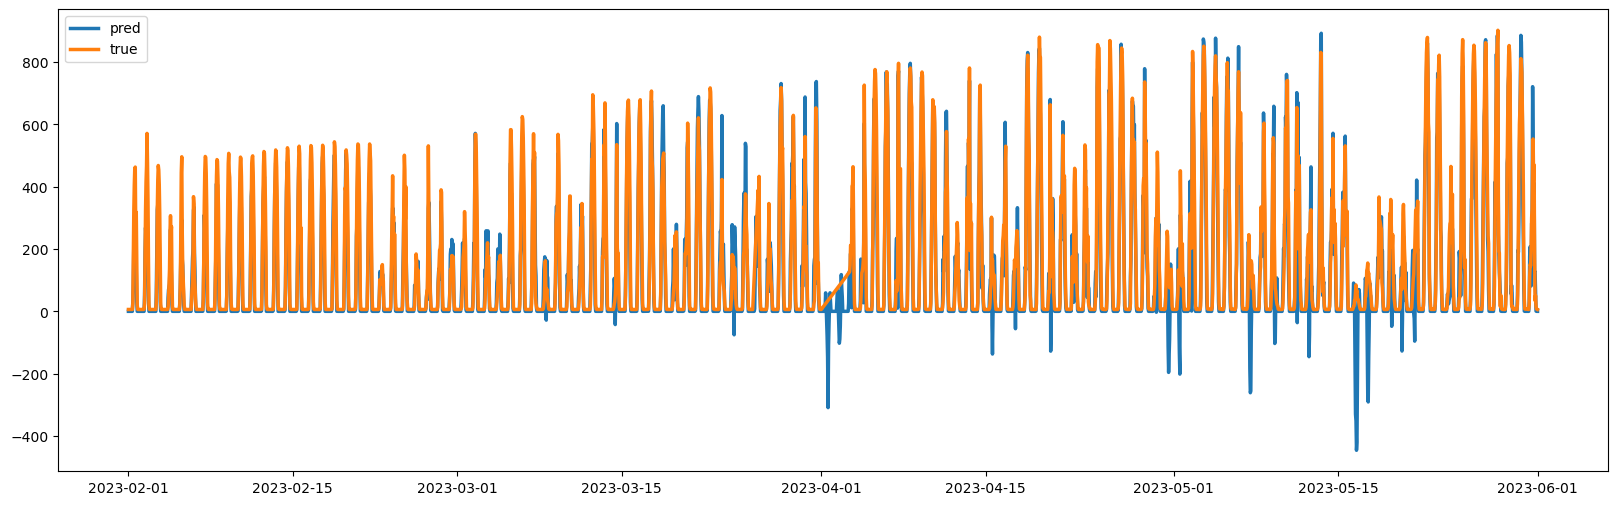

In [303]:
plt.plot(pred, label = 'pred')
plt.plot(true, label = 'true')
plt.legend()
plt.show()


# Try to predcit all 3 at the same time 

In [305]:
df_ss_neb = df.drop(' nebulosity', axis =1 )

In [306]:
my_dataloader = split_set(df_ss_neb,'2022-09-01', '2022-12-01',24)

In [307]:
train = df_ss_neb[:][:'2022-12-01']
test = df_ss_neb[:]['2022-10-01':'2022-11-25']

In [308]:
X_train = torch.tensor(train.values, dtype=torch.float32)

In [309]:
X_test = torch.tensor(test.values, dtype=torch.float32)

In [310]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [311]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 24)
        self.hidden2 = nn.Linear(24, 24)
        self.hidden2 = nn.Linear(24, 24)
        self.output1 = nn.Linear(24, 1)
        # self.act_output1 = nn.Sigmoid()
        self.output2 = nn.Linear(24, 1)
        # self.act_output2 = nn.Sigmoid()
        self.output3 = nn.Linear(24, 1)
        self.act_output3 = nn.Sigmoid()
 
 
    def forward(self, x):
        x = (self.hidden1(x))
        x =(self.hidden2(x))
        # output1 = self.act_output1(self.output1(x))
        # output2 = self.act_output2(self.output2(x))
        output3 = self.act_output3(self.output3(x))
        output1 = (self.output1(x))
        output2 = (self.output2(x))
        # output3 = (self.output3(x))
        return output1, output2, output3

In [312]:
model3 = NeuralNetwork()
print(model3)

NeuralNetwork(
  (hidden1): Linear(in_features=2, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=24, bias=True)
  (output1): Linear(in_features=24, out_features=1, bias=True)
  (output2): Linear(in_features=24, out_features=1, bias=True)
  (output3): Linear(in_features=24, out_features=1, bias=True)
  (act_output3): Sigmoid()
)


In [313]:
# neb_ = torch.tensor(neb.values, dtype=torch.float32)

In [314]:
GHI_cs_ = torch.tensor(GHI_cs.values, dtype=torch.float32)
GHI_m_ = torch.tensor(GHI_m.values, dtype=torch.float32)

In [315]:
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [316]:
n_epochs = 250
batch_size = 24
 
for epoch in range(n_epochs):
    for index in my_dataloader:
        # print(index)
        y_pred = model3(index[0])
        a, n1, neb = y_pred
        # calculating squared difference between target and predicted values 
        diff = torch.square(index[0][:,1] - (1- (a * torch.pow(neb, n1)))* index[0][:,1])
        loss = torch.sum(diff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.0011991848004981875
Finished epoch 1, latest loss 0.00038705929182469845
Finished epoch 2, latest loss 7.253629883052781e-05
Finished epoch 3, latest loss 1.4249990272219293e-05
Finished epoch 4, latest loss 3.1629933801013976e-06
Finished epoch 5, latest loss 6.346768941511982e-07
Finished epoch 6, latest loss 1.1494736895656388e-07
Finished epoch 7, latest loss 2.735241899642915e-08
Finished epoch 8, latest loss 5.3718718362461004e-09
Finished epoch 9, latest loss 5.413851589253227e-10
Finished epoch 10, latest loss 3.752655131084026e-11
Finished epoch 11, latest loss 1.5570461586733586e-12
Finished epoch 12, latest loss 1.3877787807814457e-13
Finished epoch 13, latest loss 3.8191672047105385e-14
Finished epoch 14, latest loss 1.9095836023552692e-14
Finished epoch 15, latest loss 4.773959005888173e-15
Finished epoch 16, latest loss 0.0
Finished epoch 17, latest loss 0.0
Finished epoch 18, latest loss 0.0
Finished epoch 19, latest loss 0.0
Finished epoc

Test on trained data

In [125]:
a, n, neb = model3(X_train)

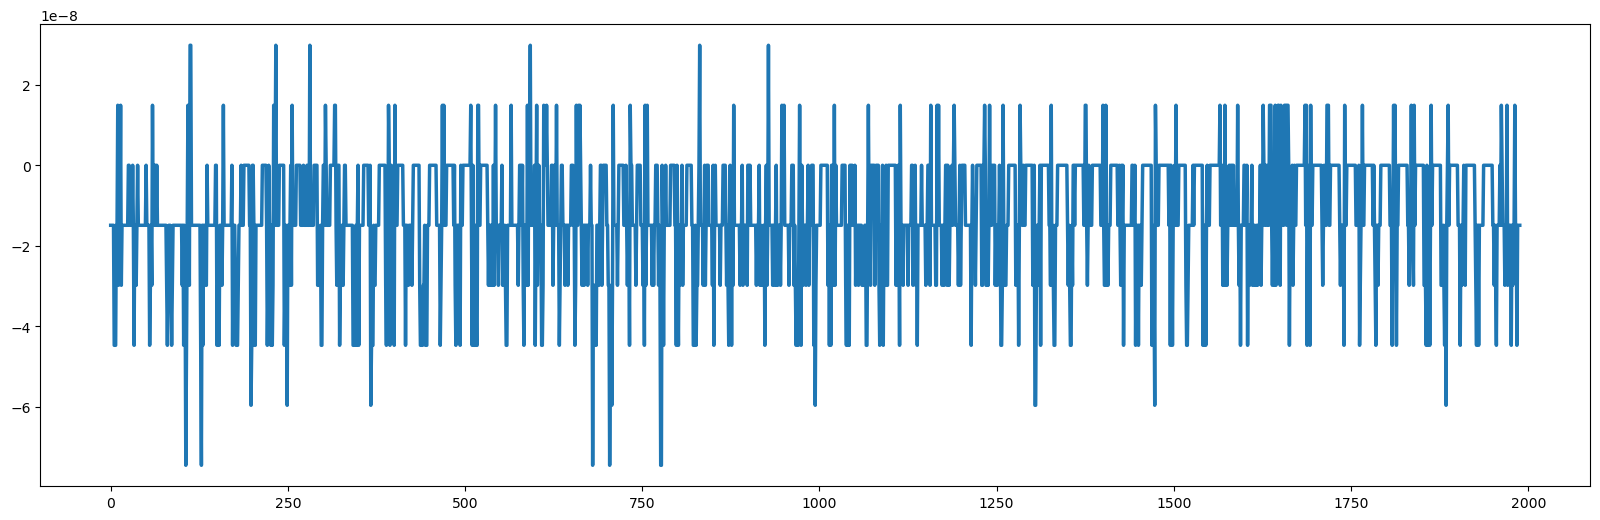

In [126]:
plt.plot(a.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


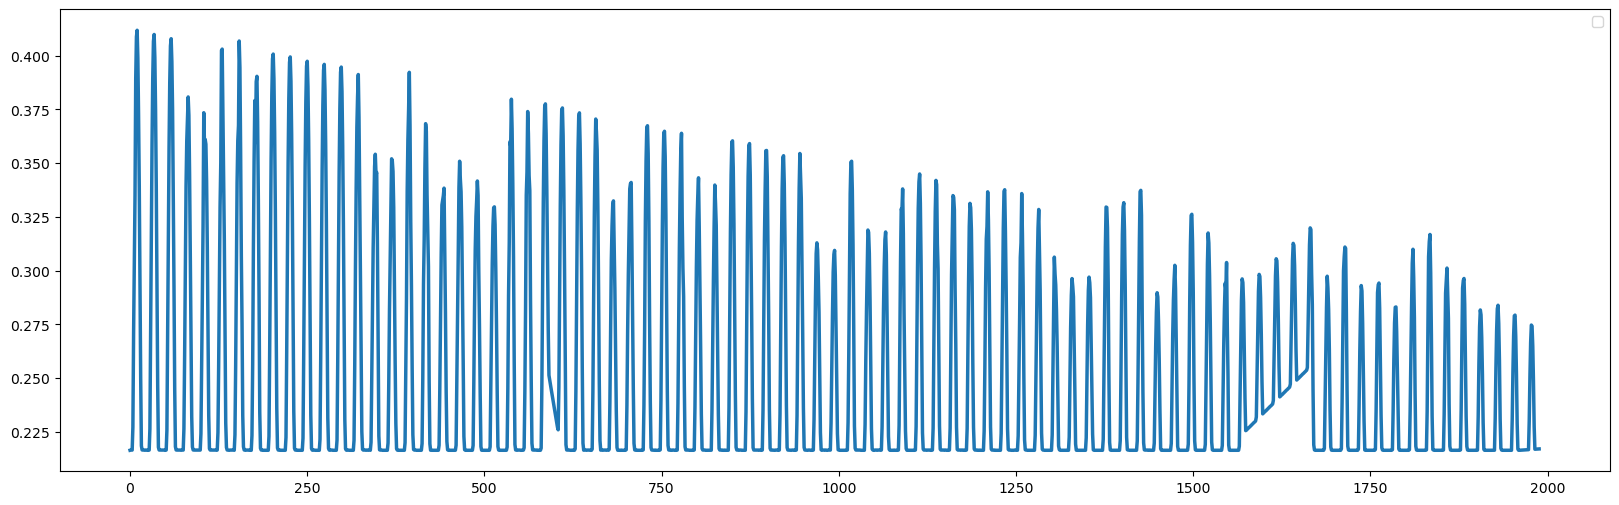

In [127]:

plt.plot(n.detach().numpy().flatten())
plt.legend()
plt.show()

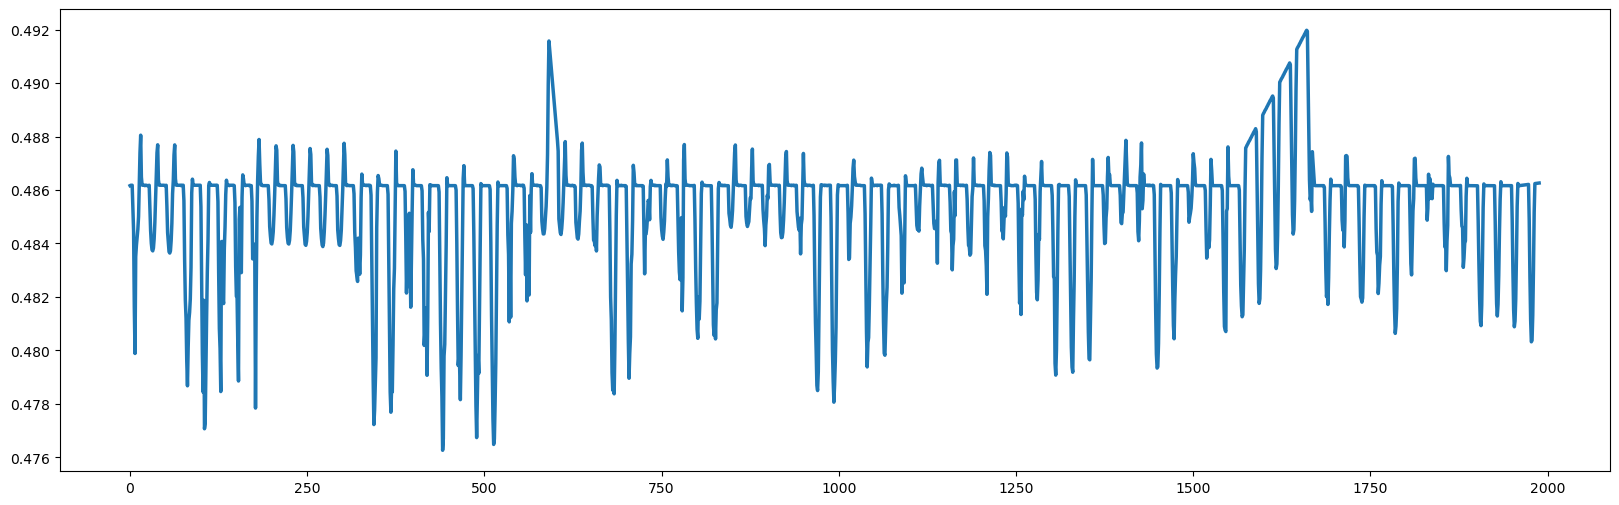

In [128]:
plt.plot(neb.detach().numpy().flatten(), label = 'neb')

In [129]:
len(a)

1989

In [130]:
ghi_cs = df['ghi_cs'][:'2022-12-01']

In [131]:
# neb = df[' nebulosity'][:'2022-10-01']

In [132]:
pred = GHI_cs.copy()[:'2022-12-01']
pred.columns = ['pred_']

In [133]:
pred

pred_
2022-09-10 04:00:00  0.000000
2022-09-10 05:00:00  0.000000
2022-09-10 06:00:00  0.000000
2022-09-10 07:00:00  0.000000
2022-09-10 08:00:00  0.056038
...                       ...
2022-12-01 19:00:00  0.000000
2022-12-01 20:00:00  0.000000
2022-12-01 21:00:00  0.000000
2022-12-01 22:00:00  0.000000
2022-12-01 23:00:00  0.000000

[1989 rows x 1 columns]

In [134]:
pred['pred_'] = ((1-a.detach().numpy().flatten()*np.power(neb.detach().numpy().flatten(), n.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [135]:
true = GHI_m[:'2022-12-01']*1000

In [136]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 120.30 RMSE
RMSE en % :  16.190857121972996


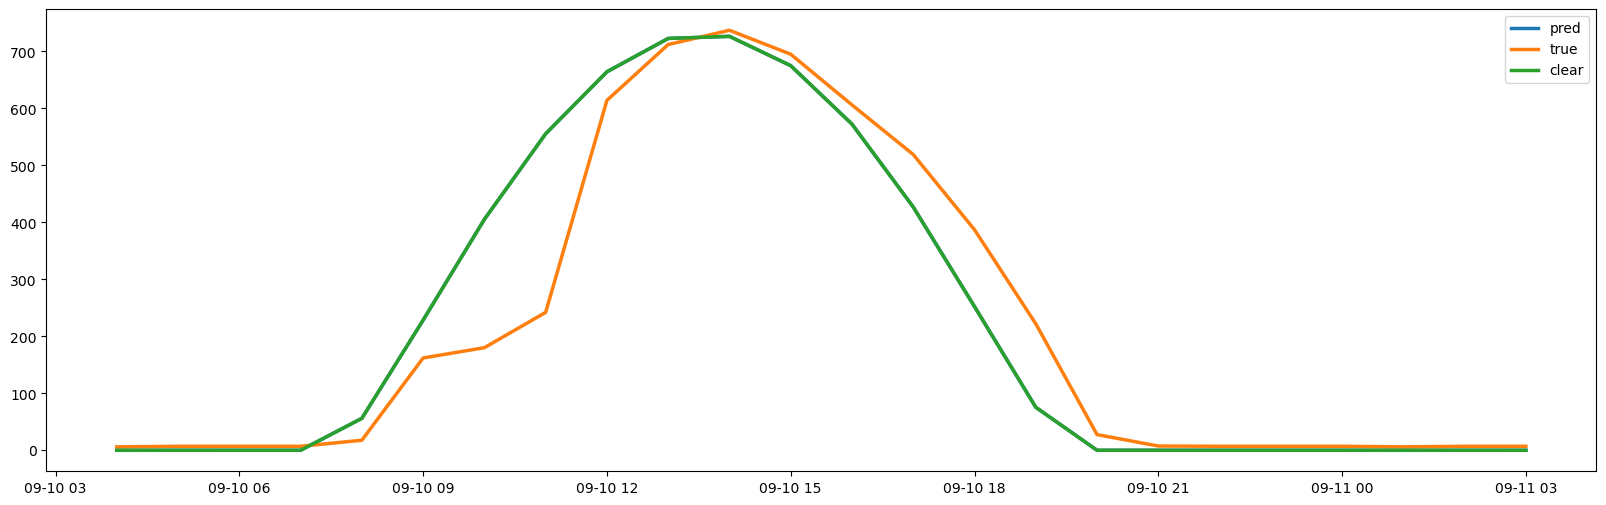

In [137]:
plt.plot(pred[:24], label = 'pred')
plt.plot(true[:24], label = 'true')
plt.plot(ghi_cs[:24]*1000, label = 'clear')
plt.legend()
plt.show()


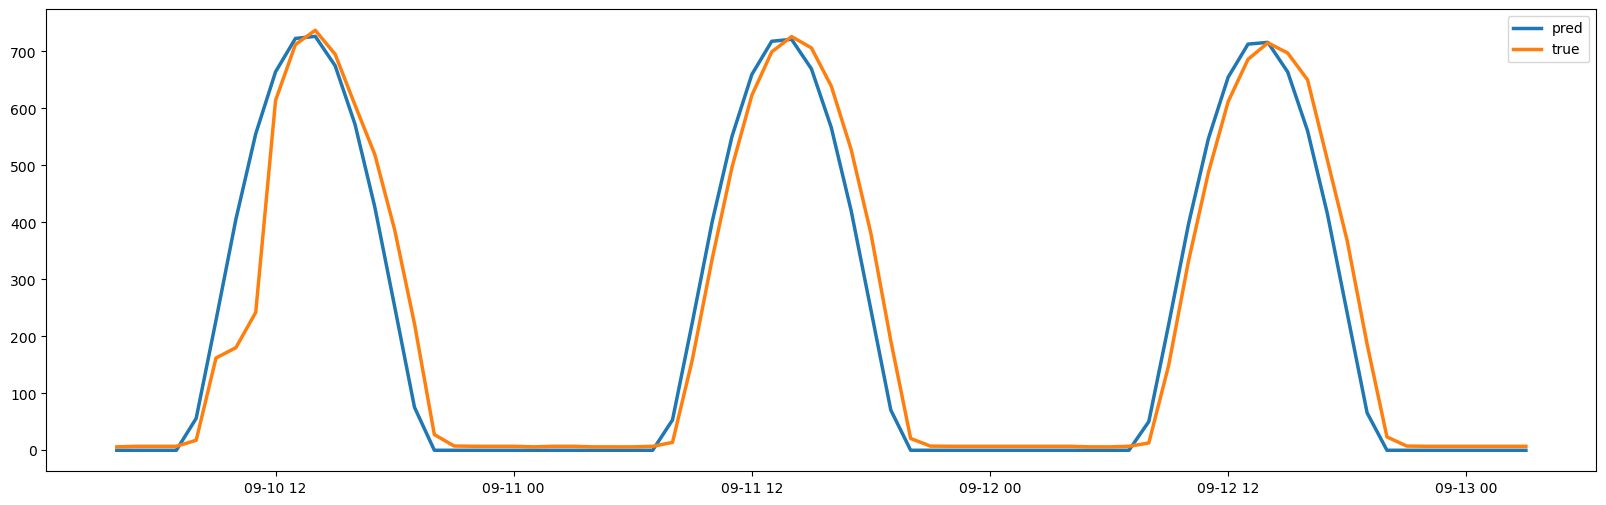

In [138]:
plt.plot(pred[:72], label = 'pred')
plt.plot(true[:72], label = 'true')
plt.legend()
plt.show()